In [2]:
%%capture
!pip install yahoo-finance

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from cointegration_tests import determine_cointegration
from helper import plot_pair, trim_and_split_data

### Pull S&P 500 data

In [5]:
def get_historical_prices(tickers, start_date, end_date):
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    all_prices = pd.DataFrame(index=date_range.date)

    for ticker in tickers:
        try:
            data = yf.download(ticker, start=start_date, end=end_date)
            all_prices[ticker] = data['Adj Close']
        except Exception as e:
            print(f"Failed to fetch data for {ticker}: {e}")

    return all_prices

In [4]:
# get the snp 500 list
snp = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
snp = snp[0]['Symbol'].unique()

In [ ]:
# pulling daily prices for all snp list for 10 years

end_date = datetime.now()
start_date = end_date - timedelta(days=365 * 10)

historical_prices = get_historical_prices(snp, start_date, end_date)


### Clean the data

In [7]:
df_hist_cleaned = historical_prices.dropna(axis=1, how='all').dropna(axis=0, how='all')

# get the year and week dates and indexes
df_hist_cleaned['Year-Week'] = [dt.isocalendar()[:2] for dt in df_hist_cleaned.index]
df_hist_cleaned['Date'] = df_hist_cleaned.index
df_hist_cleaned['Idx'] = np.arange(df_hist_cleaned.shape[0])

# get the start and end date/index of each week
weekly_dates = df_hist_cleaned.groupby('Year-Week')[['Date', 'Idx']].agg(['min', 'max'])
weekly_dates.columns = [col[0] + '-' + col[1] for col in weekly_dates.columns]

### Find all possible pair combinations

In [10]:
# find all posiible pairs
import itertools
available_tickers = [col for col in df_hist_cleaned.columns if col not in ['Year-Week', 'Date', 'Idx']]
ticker_combinations = list(itertools.combinations(available_tickers, 2))
print(f"Total of {len(ticker_combinations)} combinations available")

Total of 125250 combinations available


In [12]:
# using the first 5 years data for the test

start_date = datetime.now().date() - timedelta(days=365 * 10)
end_date = datetime.now().date() - timedelta(days=365 * 5)
print("Cointegration test timeline:")
print(f"Start date : {start_date}")
print(f"End date   : {end_date}")

Cointegration test timeline:
Start date : 2014-02-20
End date   : 2019-02-19


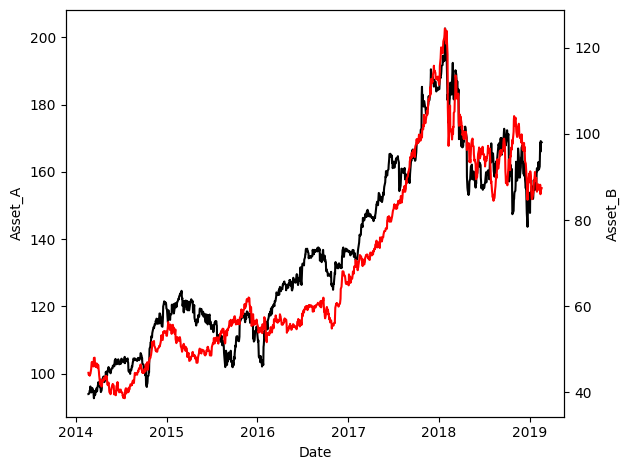

Cointegrated Pair MMM, CBOE


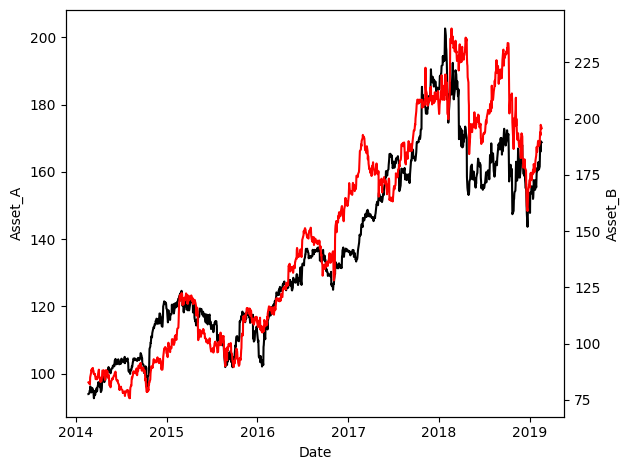

Cointegrated Pair MMM, HII


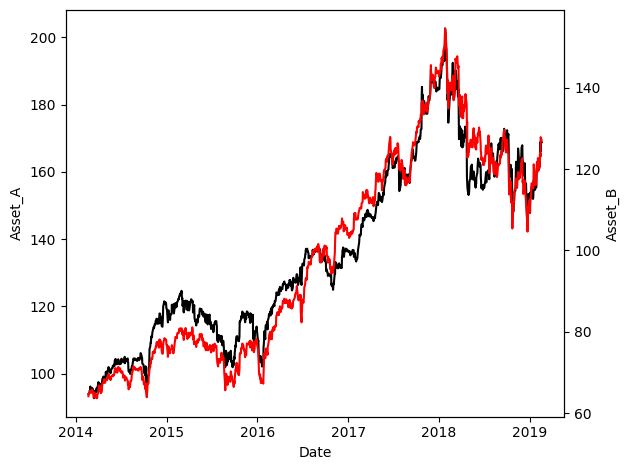

Cointegrated Pair MMM, ITW


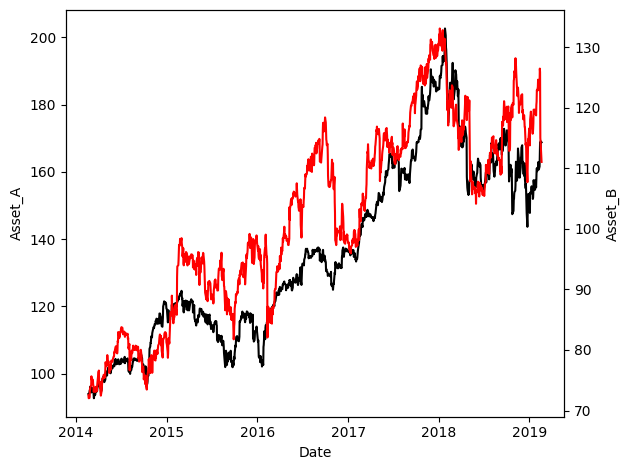

Cointegrated Pair MMM, IFF


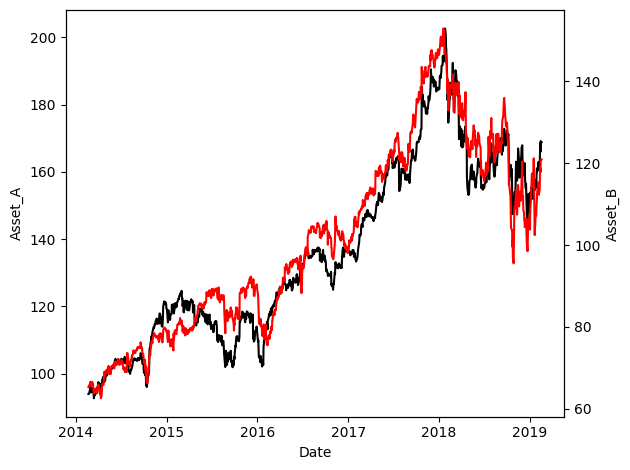

Cointegrated Pair MMM, SWK


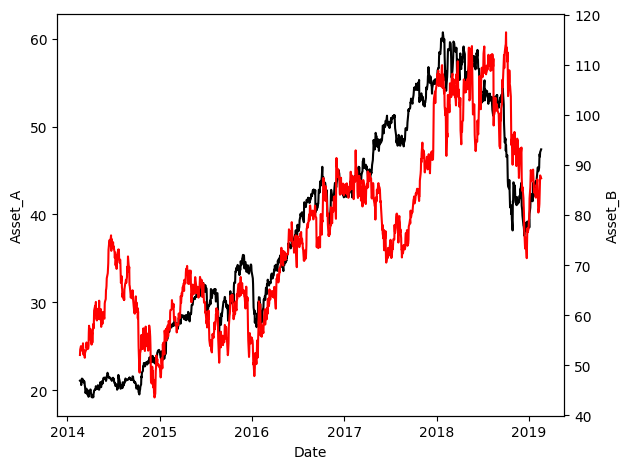

Cointegrated Pair AOS, FANG


In [18]:
cointegration_result = {}
cointegration_pairs = []
# Find the cointegrated pairs
count = 0
for i in range(len(ticker_combinations)):
  ticker_a, ticker_b = ticker_combinations[i]
  data_a, data_b = df_hist_cleaned[ticker_a], df_hist_cleaned[ticker_b]

  train_data_a, test_data_a = trim_and_split_data(data_a, start_date, end_date)
  train_data_b, test_data_b = trim_and_split_data(data_b, start_date, end_date)

  if train_data_a.isna().sum() > 0 or train_data_b.isna().sum() > 0:
    null_series = None
    non_null_series = None

    if train_data_a.isna().sum() > 0:
      train_data_a = train_data_a.dropna()
      train_data_b = train_data_b[train_data_a.index]
    else:
      train_data_b = train_data_b.dropna()
      train_data_a = train_data_a[train_data_b.index]
  try:
    if len(train_data_a) > 100:
      cointegration_result[(ticker_a, ticker_b)] = determine_cointegration(train_data_a.fillna(method='ffill'), train_data_b.fillna(method='ffill'), False)

      if sum(cointegration_result[(ticker_a, ticker_b)]) > 2:
        cointegration_pairs.append((ticker_a, ticker_b))
        plot_pair(train_data_a, train_data_b)
        print(f"Cointegrated Pair {ticker_a}, {ticker_b}")
        count += 1
        if count > 5:
          break


  except Exception as e:
    print(f"Pair {ticker_a}, {ticker_b} has a problem \n", e)

In [19]:
# import pickle

# with open('coint_results.pkl', 'wb') as p:
#   pickle.dump(cointegration_result, p)

# with open('coint_pairs.pkl', 'wb') as p:
#   pickle.dump(cointegration_pairs, p)



In [20]:
print(f"Found total {len(cointegration_pairs)} cointegrated pairs")

Found total 1890 cointegrated pairs
